# Gerrymandering Notebook

Based on GerryChain package.

Sources:

- https://github.com/mggg-states/PA-shapefiles

- https://ballotpedia.org/Redistricting_in_Pennsylvania#cite_note-indy-2

- https://github.com/uwescience/dssg2021-redistricting/blob/main/Georgia/GA_gerrychain.py

In [2]:
pip install gerrychain  ## *****

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import re
import tqdm

import csv
import json
import random
import math
import numpy

from functools import partial, reduce
import pandas
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn

import gerrychain

from gerrychain import (
     Election,
     Graph,
     MarkovChain,
     Partition,
     accept,
     constraints,
     updaters
)

import networkx as nx

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, wasted_votes, partisan_bias
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
from gerrychain.accept import always_accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
within_percent_of_ideal_population, UpperBound)

In [4]:
## utility_functions, used to create the graph of nodes

def plot_district_map(df, assignment_dict, title=None, output_path=None, map_colors=None):
    """
    visualize districts corresponding to a given assignment_dict
    mapping index in geopandas dataframe to desired districts per node
    If output_path not provided, will just display image. Otherwise save to location
    
    To customize map colors, input chosen string name of matplotlib's built-in colormaps in map_colors
    If map_colors not provided, cmap will be set to default
    https://matplotlib.org/stable/gallery/color/colormap_reference.html
    https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    df['district_assignment'] = df.index.map(assignment_dict)
    df.plot(column='district_assignment', edgecolor=(1, 1, 1, 0.05), 
            cmap=map_colors, figsize=(12, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()


def add_other_population_attribute(graph, total_column_list=["VAP"],
                                   target_population_column_list=["BVAP"],
                                   other_population_name="nBVAP"):
    """
     calculates other population value by finding difference between total
     population and target population. For example, return graph with
     non-BVAP attribute using VAP & BVAP values

    :param graph: networkx graph object
    :param total_column_list: list of all attributes to consider in the 'total population' (e.g. VAP)
    :param target_population_column_list: list of all attributes to consider in the 'target population' (e.g. BVAP)
    :param other_population_name: string - identifer for other population
    :return:
    """

    for node in graph.nodes():
        total_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                              for att in total_column_list])
        target_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                               for att in target_population_column_list])
        graph.nodes[node][other_population_name] = total_sum - target_sum

    return graph

def convert_attributes_to_int(graph, attribute_list):
    """
    helper function for casting attributes from string to int
    """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = int(float(graph.nodes[n][attribute]))

    return graph

def convert_attributes_to_float(graph, attribute_list):
    """
     helper function for casting attributes from string to float
     """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = float(graph.nodes[n][attribute])
    return graph


def export_all_metrics_per_chain(chain, output_path,
                                 buffer_length=2000,
                                 include_election=True,
                                 exclude_metrics=['cut_edges', 'boundary_nodes',
                                                  'cut_edges_by_part',
                                                  'area', 'perimeter',
                                                  'interior_boundaries', 'exterior_boundaries'
                                                  ]
                                 ):

    """
    save all metrics for every k steps (k=buffer length) of chain in separate csv file
    Additionally, saves partition assignment at kth step of chain as json

    :param chain: GerryChain chain generator object
    :param output_path: folder to save results in (separate dir per chain)
    :param buffer_length: frequency at which data is written to file
    :param include_election: boolean - specifies whether election related metrics should be saved
    :param exclude_metrics: list - metrics to exclude from output files. All metrics not at district level
                            should be excluded.
    :return:
    """

    os.makedirs(output_path, exist_ok=True)

    all_res = []
    election_res = []
    for i, part in enumerate(chain):
        results = export_all_metrics_per_partition(part, include_election, exclude_metrics)
        all_res.append(results[0].values)

        if include_election:
            election_res.append(results[1].values)

        # save results every i = buffer_length steps
        if (i+1) % buffer_length == 0:
            print(i+1)

            # save non-election related metric results
            for n, metric_name in enumerate(results[0].columns):
                with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                    writer = csv.writer(f, lineterminator="\n")
                    writer.writerows(np.array(all_res)[:, :, n])

            all_res = []

            if include_election:
                # save election related metric results
                for n, metric_name in enumerate(results[1].columns):
                    if metric_name == 'percent': #different format - save per election in sep file
                        for row, election_name in enumerate(results[1].index):
                            with open(os.path.join(output_path, f"{election_name}_{metric_name}_{str(i+1)}.csv"), 'w') as f:
                                writer = csv.writer(f, lineterminator='\n')
                                writer.writerows(np.array(election_res)[:, row, n])
                    else: # all other election metrics saved in single file
                        with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                            writer = csv.writer(f, lineterminator='\n')
                            writer.writerows(np.array(election_res)[:, :, n])

                election_res = []

            # save assignment for every i steps
            with open(os.path.join(output_path, f'assignment_{str(i+1)}.json'), "w") as f:
                json.dump(dict(part.assignment), f)




def export_all_metrics_per_partition(partition, include_election=True,
                                     exclude_metrics=['cut_edges']):
    """
    returns tuple of dataframes with common metrics calculated at district level
    (split by nonelection & election related)

    :param partition:
    :param include_election: boolean
    :param exclude_metrics: metrics tracked in updater to exclude from export
    :return: returns tuple of dataframe - (nonelection related metrics, election related metrics)
    """
    metric_results = {}
    for name, func in partition.updaters.items():
        if type(func) == Election or name in exclude_metrics:
            continue
        metric_results[name] = partition[name]

    metric_results = pd.DataFrame.from_dict(metric_results)

    if include_election:
        election_results=export_election_metrics_per_partition(partition)
        return (metric_results, election_results)

    return (metric_results,)


def export_election_metrics_per_partition(partition):
    """
    returns dataframe with following metrics for all elections tracked in updater
    using the given partition

    * percent won by first party
    * mean_median score
    * efficiency gap
    * seats won

    :param partition:
    :return: pd dataframe election_results
    """
    elections_info = {}

    # identify elections related updaters being tracked per partition
    for name, func in partition.updaters.items():
        if type(func) == Election:
            elections_info[name] = func.parties

    election_results = {name: {} for name in elections_info.keys()}

    # store stats for each election
    for election_name, parties in elections_info.items():
        election_results[election_name]['percent'] = partition[
            election_name].percents(parties[0])
        election_results[election_name]['efficiency_gap'] = efficiency_gap(
            partition[election_name])
        election_results[election_name]['mean_median'] = mean_median(
            partition[election_name])
        election_results[election_name]['wins'] = partition[
            election_name].wins(parties[0])

    return pd.DataFrame.from_dict(election_results, orient='index')

In [5]:
# Create graph and df objects from data *****
graph = Graph.from_file("/work/data/PA/PA.shp") # Must be adapted for each person's directory
df = gpd.read_file("/work/data/PA/PA.shp")      # Must be adapted for each person's directory




/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [6]:

# Data: each row is a VDT, each column is demographic/electoral information
# Glossary of what each field means: https://github.com/mggg-states/PA-shapefiles

# Over 9000 VDTs


df

STATEFP10 COUNTYFP10 VTDST10   GEOID10 VTDI10  \
0           42        085     960  42085960      A   
1           42        039      40   4203940      A   
2           42        039      10   4203910      A   
3           42        039      20   4203920      A   
4           42        039      30   4203930      A   
...        ...        ...     ...       ...    ...   
9250        42        001     100  42001100      A   
9251        42        001     480  42001480      A   
9252        42        001     260  42001260      A   
9253        42        001      10   4200110      A   
9254        42        001      40   4200140      A   

                               NAME10                       NAMELSAD10 LSAD10  \
0               SHENANGO TWP VTD WEST            SHENANGO TWP VTD WEST     00   
1     BLOOMING VALLEY Voting District  BLOOMING VALLEY Voting District     00   
2          ATHENS TWP Voting District       ATHENS TWP Voting District     00   
3          BEAVER TWP Voting District       BEAVER TWP Voting District     00   
4      BLOOMFIELD TWP Voting District   BLOOMFIELD TWP Voting District     00   
...                               ...                              ...    ...   
9250              CONEWAGO TWP VTD 02              CONEWAGO TWP VTD 02     00   
9251                        UNION TWP        UNION TWP Voting District     V2   
9252                     HAMILTON TWP     HAMILTON TWP Voting District     V2   
9253                      ABBOTTSTOWN      ABBOTTSTOWN Voting District     V2   
9254                      BERWICK TWP      BERWICK TWP Voting District     V2   

     MTFCC10 FUNCSTAT10  ...  TS  CD_2011 SEND HDIST  538DEM  538GOP  \
0      G5240          N  ...   3        3   50     7      03      03   
1      G5240          N  ...   5        3   50     6      03      03   
2      G5240          N  ...   5        3   50    65      03      03   
3      G5240          N  ...   3        3   50    17      03      03   
4      G5240          N  ...   5        3   50    65      03      03   
...      ...        ...  ...  ..      ...  ...   ...     ...     ...   
9250   G5240          N  ...   4        4   33    91      09      04   
9251   G5240          N  ...   4        4   33    91      09      04   
9252   G5240          N  ...   4        4   33   193      09      04   
9253   G5240          N  ...   4        4   33   193      09      04   
9254   G5240          N  ...   4        4   33   193      09      04   

      538CMPCT   GOV14D   GOV14R  \
0           03  290.000  242.000   
1           03   45.000   97.000   
2           03   48.000  156.000   
3           03   66.000  102.000   
4           03  226.000  231.000   
...        ...      ...      ...   
9250        04  437.512  675.790   
9251        04  247.000  589.000   
9252        04  311.000  490.000   
9253        04    0.000  124.000   
9254        04  244.007  389.012   

                                               geometry  
0     POLYGON ((37033.427 4574062.719, 37048.711 457...  
1     POLYGON ((78941.652 4627060.081, 79147.562 462...  
2     POLYGON ((91890.036 4636341.145, 91931.180 463...  
3     POLYGON ((41746.849 4647823.741, 42071.856 464...  
4     POLYGON ((92362.943 4644867.586, 92364.853 464...  
...                                                 ...  
9250  POLYGON ((323871.047 4407084.481, 323883.195 4...  
9251  POLYGON ((320167.759 4404941.193, 320226.612 4...  
9252  POLYGON ((322636.281 4417936.773, 322698.260 4...  
9253  POLYGON ((329306.063 4417026.449, 329329.891 4...  
9254  MULTIPOLYGON (((329371.092 4417095.738, 329615...  

[9255 rows x 69 columns]

<AxesSubplot: >

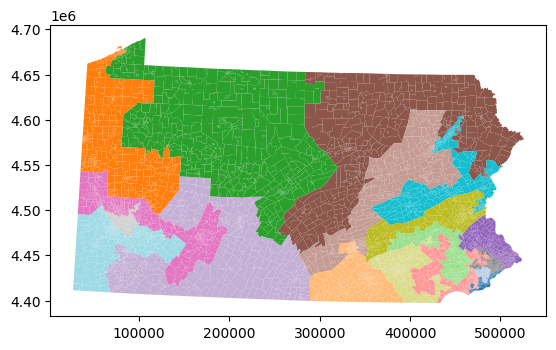

In [7]:
#--Eyeballing the state PA
df.plot(column="CD_2011", cmap="tab20")

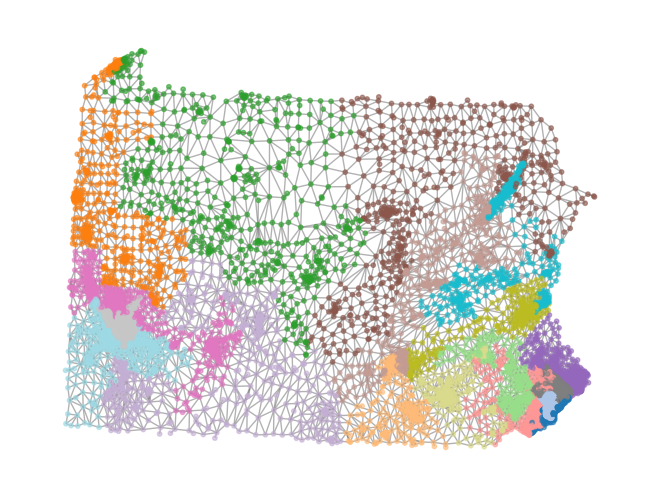

In [8]:
# Plotting the PA map as a graph

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

for node in graph.nodes():
    graph.nodes[node]["C_X"] = c_x[node]
    graph.nodes[node]["C_Y"] = c_y[node]
    
xgraph = convert_attributes_to_int(graph, ['CD_2011'])


nx.draw(xgraph,
        pos = {node:(xgraph.nodes[node]["C_X"],xgraph.nodes[node]["C_Y"]) for node in xgraph.nodes()},
        node_color=[xgraph.nodes[node]["CD_2011"] for node in xgraph.nodes()],
        node_size=10,cmap='tab20', alpha= 0.6, edge_color='gray')
plt.show()

In [9]:
#--Set some parameters based on PA
state_abbr="PA"
housen="CON"
num_districts=18
pop_col="TOTPOP"
#num_elections=4

#Make an output directory to put files in
newdir = "./Outputs/"+state_abbr+housen+"_Precincts/"
os.makedirs(newdir, exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Create Folder")

#--Generic updaters
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
updater = {
    "population": gerrychain.updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges
             }

In [10]:
#--Set some parameters based on analysis
#T16PRESD: Number of votes for 2016 Democratic Presidential candidate
#T16PRESR: Number of votes for 2016 Republican presidential candidate
#PRES12D: Number of votes for 2012 Democratic presidential candidate
#PRES12R: Number of votes for 2012 Republican presidential candidate

#T16SEND: Number of votes for 2016 Democratic senate candidate
#T16SENR: Number of votes for 2016 Republican senate candidate
#USS12D: Number of votes for 2012 Democratic senate candidate
#USS12R: Number of votes for 2012 Republican senate candidate

#VAP - Total voting age population
#HVAP - Hispanic voting age population
#WVAP - White, non-hispanic, voting age population
#BVAP - Black, non-hispanic, voting age population
#CD - US congressional district
 
election_names=[
    "PRES16",
    "PRES12",
    "BVAP",
    "HVAP",
    "WVAP",
    "BHVAP"]

num_elections = len(election_names)

election_columns=[
    ["T16PRESR", "T16PRESD"],
    ["PRES12R", "PRES12D"],
    ["BVAP", "nBVAP"],
    ["HVAP", "nHVAP"],
    ["WVAP", "nWVAP"],
    ["BHVAP", "nBHVAP"]
    ]

In [11]:
#--Setup election updaters
# Election updaters, for computing election results using the vote totals
# from our shapefile.
elections = [
    Election(
        election_names[i], #Name of election
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
        )
        for i in range(num_elections)
] 

election_updaters = {election.name: election for election in elections} 

updater.update(election_updaters)

#Coerce tabular data to correct type
totpop = 0 
for n in graph.nodes():
    totpop+= graph.nodes[n]["TOTPOP"]#The loop is going over all the precincts then adding the populations
    graph.nodes[n]["TOTPOP"] = int(graph.nodes[n]["TOTPOP"])
    graph.nodes[n]["VAP"] = int(graph.nodes[n]["VAP"])
    graph.nodes[n]["BVAP"] = int(graph.nodes[n]["BVAP"])
    graph.nodes[n]["HVAP"] = int(graph.nodes[n]["HVAP"])
    graph.nodes[n]["WVAP"] = int(graph.nodes[n]["WVAP"])
    graph.nodes[n]["CD_2011"] = int(graph.nodes[n]["CD_2011"])
    graph.nodes[n]["T16PRESR"] = int(graph.nodes[n]["T16PRESR"])
    graph.nodes[n]["T16PRESD"] = int(graph.nodes[n]["T16PRESD"])
    graph.nodes[n]["PRES12R"] = int(graph.nodes[n]["PRES12R"])
    graph.nodes[n]["PRES12D"] = int(graph.nodes[n]["PRES12D"])
    
    #Generating populations
    graph.nodes[n]["nBVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BVAP"]
    graph.nodes[n]["nHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["HVAP"]
    graph.nodes[n]["nWVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["WVAP"]
    graph.nodes[n]["BHVAP"] = graph.nodes[n]["BVAP"] + graph.nodes[n]["HVAP"]
    graph.nodes[n]["nBHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BHVAP"]
    

In [12]:
test_elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]

In [13]:
# Election objects from GerryChain:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/updaters/election.py
type(test_elections[0])

gerrychain.updaters.election.Election

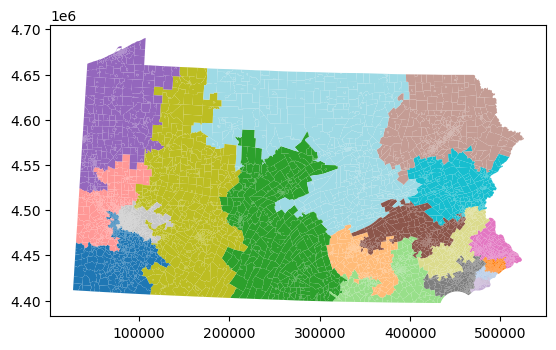

In [20]:
# One alternative: start the chain from a randomly generated tree partition (that satisfies constraints)
# (too expensive to do it 1000s of times) *****
# https://github.com/mggg-states/PA-shapefiles
# "We suggest using the function recursive_tree_part to create a seed plan as a starting point. If it is important to use one of the plans provided as a starting point for chain, adding edges on your dual graph between nodes (7648,7635) and (1247,1160) should fix connectivity problems for CD_2011 and GOV."

#--Create, Plot, and save seed plan           
cddict = recursive_tree_part(graph,
                                range(num_districts),
                                totpop/num_districts,
                                "TOTPOP",
                                .01, #1% population balance
                                1)
df['initial'] = df.index.map(cddict)


# Build initial Partition
initial_partition = Partition(graph,
                              cddict,
                              updater)



with open(newdir+"init.json", 'w') as jf1:
         json.dump(cddict, jf1) 


df.plot(column="initial", cmap="tab20") #cmap stand for color map
plt.savefig(newdir+"initial.png")
plt.show()

In [ ]:
# Another option would have been to start from 2011 map as seed instead 
 
# # Build initial Partition
# initial_partition = gerrychain.GeographicPartition(graph,
#                               "CD_2011",
#                               updater)

In [18]:
# #Write out initial statistics to file (seed plan)
# with open(newdir + "Start_Values.txt", "w") as f: 
#     f.write("Values for Starting Plan: Tree Recursive\n \n ")
#     f.write("Initial Cut: " + str(len(initial_partition["cut_edges"])))
#     f.write("\n")
#     f.write("\n")

#     for elect in range(num_elections):
#         f.write(
#             election_names[elect]
#             + "District Percentages"
#             + str(
#                 (initial_partition[election_names[elect]].percents("First"))
#             )
#         )
#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "Mean-Median :"
#             + str(mean_median(initial_partition[election_names[elect]]))
#         )

#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "Efficiency Gap :"
#             + str(efficiency_gap(initial_partition[election_names[elect]]))
#         )

#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "How Many Seats :"
#             + str(initial_partition[election_names[elect]].wins("First"))
#         )

#         f.write("\n")
#         f.write("\n")
        
#         for dist in range(14):
#             f.write(
#                 election_names[elect]    #wasted votes
#                 + "Wasted Votes :"
#                 + str(wasted_votes(initial_partition[election_names[elect]].votes("First")[dist],
#                                    initial_partition[election_names[elect]].votes("Second")[dist]))
#             )
    
#             f.write("\n")
#             f.write("\n")


KeyError: 'cut_edges'

In [21]:
#Initialize Proposal (ReCom) *****

# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by discarding unbalanced partitions early on.

ideal_population = sum(initial_partition["population"].values())/ len(initial_partition)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)    

In [22]:
#Create Constraints (compactness) *****
#To keep districts about as compact as the original plan, 
#we bound the number of cut edges at 2 times the number 
#of cut edges in the initial plan.
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"]) 
)

# it said 'change from 0.02 for GA population balance' so... change for PA?
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.01) 

In [ ]:
## Consider acceptance function that prioritizes county split minimization

# alternative -> move towards plans that have fewer county splits
# def minimize_county_split_accept(partition):
    
#     df['prev'] = df.index.map(partition.parent.assignment.to_dict())
#     df['current'] = df.index.map(partition.assignment.to_dict())

#     max_split_prev = max(df.groupby('COUNTYFP10')['prev'].nunique())
#     max_split_curr = max(df.groupby('COUNTYFP10')['current'].nunique())
    
    
#     if max_split_curr <= max_split_prev: # accept all plans that have fewer county splits than parent plan
#         return True
    
#     elif random.random() < .25: # randomly accept plans that have more county splits with 25% probability
#         return True
#     else:
#         return False


In [ ]:
# Iterations of Voting Rights Act implementations: 
# code for Texas: https://github.com/uwescience/dssg2021-redistricting/blob/main/Texas/03_TX_model.py

# effectiveness_cutoff = .6
# def effective_districts(dictionary):
#     """
#     Given district effectiveness distributions, this function returns the total districts
#     that are above the effectivness threshold for Black and Latino voters, and the total
#     distinct effective districts.
#     """
#     black_threshold = effectiveness_cutoff
#     hisp_threshold = effectiveness_cutoff
    
#     if "N/A" not in dictionary.values():
#         hisp_effective = [i+l for i,j,k,l in dictionary.values()]
#         black_effective = [j+l for i,j,k,l in dictionary.values()]
        
#         hisp_effect_index = [i for i,n in enumerate(hisp_effective) if n >= hisp_threshold]
#         black_effect_index = [i for i,n in enumerate(black_effective) if n >= black_threshold]
        
#         total_hisp_final = len(hisp_effect_index)
#         total_black_final = len(black_effect_index)
#         total_distinct = len(set(hisp_effect_index + black_effect_index))
       
#         return total_hisp_final, total_black_final, total_distinct
    
#     else:
#         return "N/A", "N/A", "N/A"

# def inclusion(partition):
#     """
#     Returns 'True' if proposed plan has greater than or equal to the number of Black, Latino and 
#     distinct effective districts as the enacted map.
#     """
#     final_state_prob, final_equal_prob, final_dist_prob = partition["final_elec_model"]
#     inclusion_dict = final_state_prob if model_mode == 'statewide' else final_equal_prob if model_mode == 'equal' else final_dist_prob
#     hisp_vra_dists, black_vra_dists, total_distinct = effective_districts(inclusion_dict)
    
#     return total_distinct >= enacted_distinct and \
#           black_vra_dists >= enacted_black and hisp_vra_dists >= enacted_hisp

# enacted_hisp = 1
# enacted_black = 1

# def inclusion_demo(partition):
#     """
#     Returns 'True' if proposed plan has at least 8 districts over 45% HVAP and at least
#     4 over 25% BVAP.
#     """
#     bvap_share_dict = {d:partition["BVAP"][d]/partition["VAP"][d] for d in partition.parts}
#     hvap_share_dict = {d:partition["HVAP"][d]/partition["VAP"][d] for d in partition.parts}       
#     bvap_share = list(bcvap_share_dict.values())
#     hvap_share = list(hcvap_share_dict.values())
    
#     hvap_over_thresh = len([k for k in hvap_share if k > .45])
#     bvap_over_thresh = len([k for k in bvap_share if k > .25 ])
#     return (hvap_over_thresh >= enacted_hisp and bvap_over_thresh >= enacted_black)


# #Build a constraint that rejects a plan if there is a district with BVAP% over 60%
# def sixty_BVAP_accept(partition): 
    
#     new = sum(x<.6 for x in partition["BVAP"].percents("First"))
    
#     old = sum(x<.6 for x in partition.parent["BVAP"].percents("First"))
    
#     if new > old:       
#         return True
    
#     else:
#         return False 

# new = 0
# for x in partition["BVAP"].percents("First"):
#     if x < 0.6:
#         new = new+x


# def inclusion_demo2(partition):
#     new = sum(x>.4 for x in partition["BVAP"].percents("First"))
#     if new < 2:
#         return False
#     else:
#         return True




# # VRA implementation for M-H score function

# first_bvap_thresh = .54
# second_bvap_thresh = .27

# def VRA_score_function(partition):
    
#     bvap_percs = sorted(partition["BVAP"].percents("First"))
#     first_bvap_part = bvap_percs[-1]
#     second_bvap_part = bvap_percs[-2]

#     j_m = math.sqrt((first_bvap_thresh - first_bvap_part)**2 + (second_bvap_thresh - second_bvap_part)**2)



#     new = sum(x>.4 for x in partition["BVAP"].percents("First"))
#     if new < 2:
#         return False
#     else:
#         return True



In [ ]:
# VRA implementation with hard thresholds
first_bvap_thresh = .54
second_bvap_thresh = .27

# def VRA_cutoffs(partition):
    
#     bvap_percs = sorted(partition["BVAP"].percents("First"))
#     first_bvap_part = bvap_percs[-1]
#     second_bvap_part = bvap_percs[-2]

#     if (abs(first_bvap_thresh - first_bvap_part) < 10) and (abs(second_bvap_thresh - second_bvap_part) < 10):
#         return True
#     else:
#         return False


In [23]:
## Combining county splits and VRA into a single accept function *****

# VRA implementation with hard thresholds
first_bvap_thresh = .54
second_bvap_thresh = .27

def county_VRA_accept(partition):
    df['prev'] = df.index.map(partition.parent.assignment.to_dict())
    df['current'] = df.index.map(partition.assignment.to_dict())

    max_split_prev = max(df.groupby('COUNTYFP10')['prev'].nunique())
    max_split_curr = max(df.groupby('COUNTYFP10')['current'].nunique())

    bvap_percs = sorted(partition["BVAP"].percents("First"))
    first_bvap_part = bvap_percs[-1]
    second_bvap_part = bvap_percs[-2]

    VRA_condition = (abs(first_bvap_thresh - first_bvap_part) < 10) and (abs(second_bvap_thresh - second_bvap_part) < 10)

    if not VRA_condition:
        return False

    if max_split_curr <= max_split_prev: # accept all plans that have fewer county splits than parent plan
        return True
    
    elif random.random() < .25: # randomly accept plans that have more county splits with 25% probability
        return True
    else:
        return False


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2 [00:00<?, ?it/s]

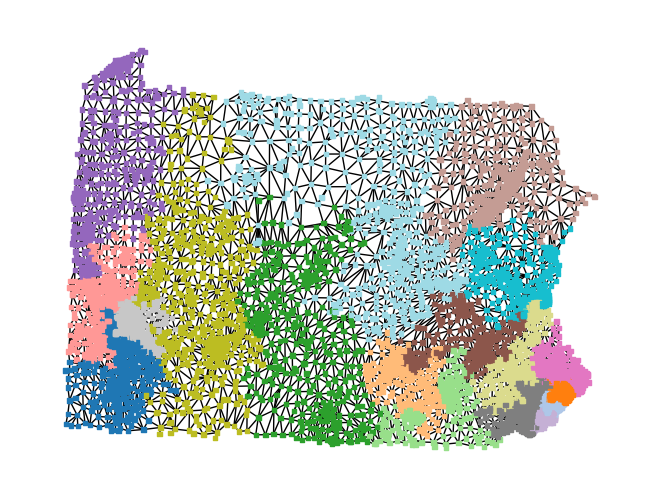

 50%|█████     | 1/2 [00:20<00:20, 20.88s/it]

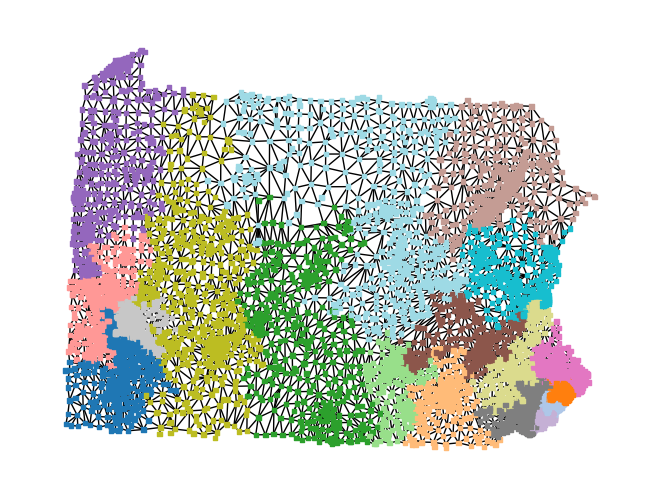

100%|██████████| 2/2 [00:42<00:00, 21.49s/it]


In [24]:

# Generating maps to show recom vs flip method (gif generation, pictures, animations, compare, flip vs recom)
# (comparison)

####CONFIGURE UPDATERS

ns=10

updaters = election_updaters

tree_proposal = partial(recom,
                       pop_col="population",
                       pop_target=ideal_population,
                       epsilon=0.05,
                       node_repeats=1
                      )

grid_partition = Partition(xgraph,assignment=cddict,updaters=updaters)

#########BUILD PARTITION
#######BUILD MARKOV CHAINS
anim_recom_chain=MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound,
        # inclusion_demo
    ],    
    accept= county_VRA_accept, # minimize_county_split_accept, 
    initial_state=initial_partition,
    total_steps=2
)

#########Run MARKOV CHAINS
#recom

#rsw = []
#rmm = []
#reg = []
#rce = []
i = 0

for part in anim_recom_chain.with_progress_bar():
    #rsw.append(part["PRES16"].wins("First"))
    #rmm.append(mean_median(part["PRES16"]))
    #reg.append(efficiency_gap(part["PRES16"]))
    #rce.append(len(part["cut_edges"]))
    plt.figure()
    nx.draw(xgraph, 
            pos = {node:(xgraph.nodes[node]["C_X"],xgraph.nodes[node]["C_Y"]) for node in xgraph.nodes()},
            node_color = [dict(part.assignment)[x] for x in xgraph.nodes()] ,
            node_size = ns, 
            node_shape ='s',
            cmap = 'tab20')
    plt.savefig(f"/work/Figures/recom_{i}.png")
    plt.show()
    
    i = i + 1


  0%|          | 0/10 [00:00<?, ?it/s]

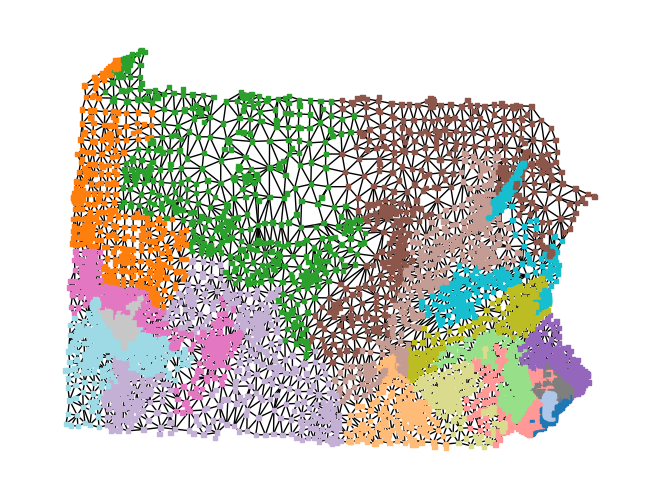

 10%|█         | 1/10 [00:12<01:52, 12.55s/it]

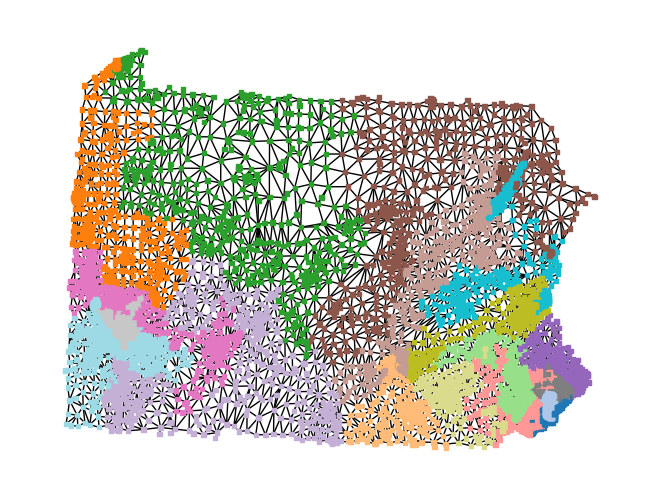

 20%|██        | 2/10 [00:25<01:41, 12.70s/it]

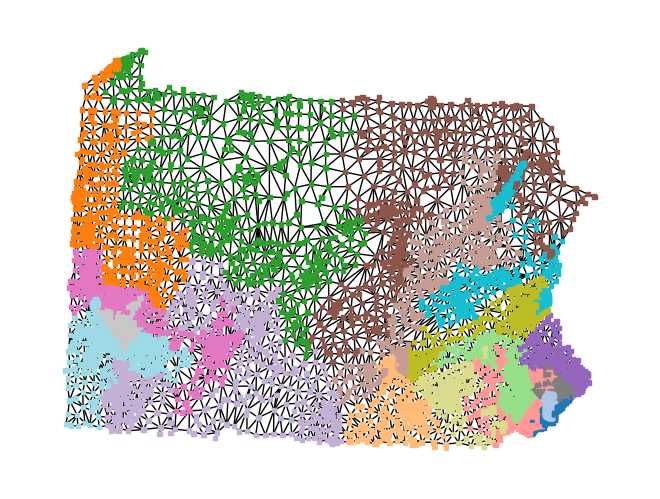

 30%|███       | 3/10 [00:38<01:30, 12.92s/it]

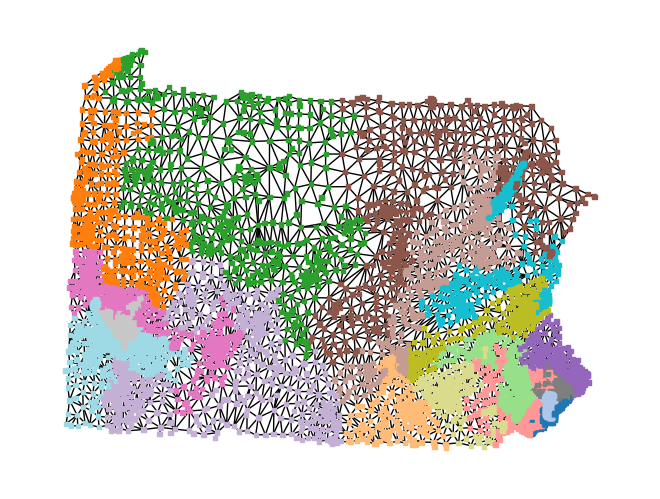

 40%|████      | 4/10 [00:51<01:16, 12.80s/it]

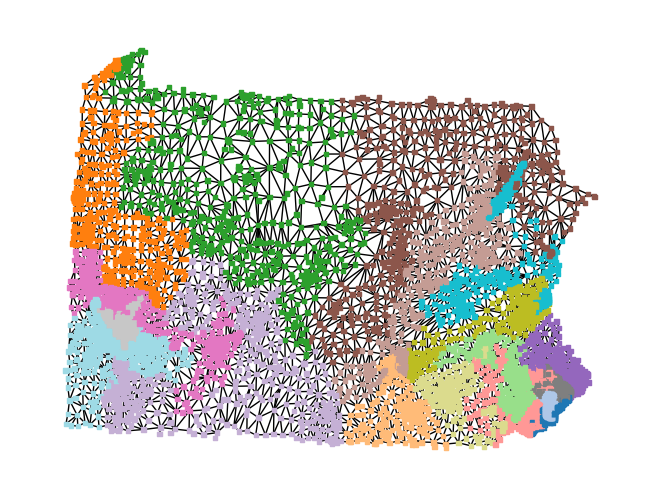

 50%|█████     | 5/10 [01:04<01:05, 13.04s/it]

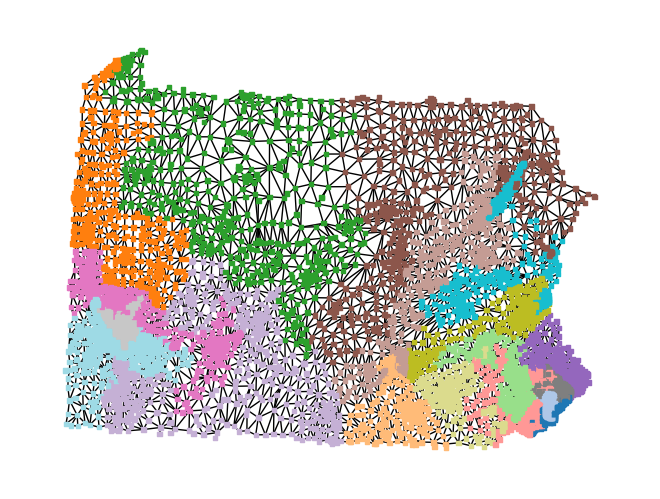

 60%|██████    | 6/10 [01:17<00:52, 13.04s/it]

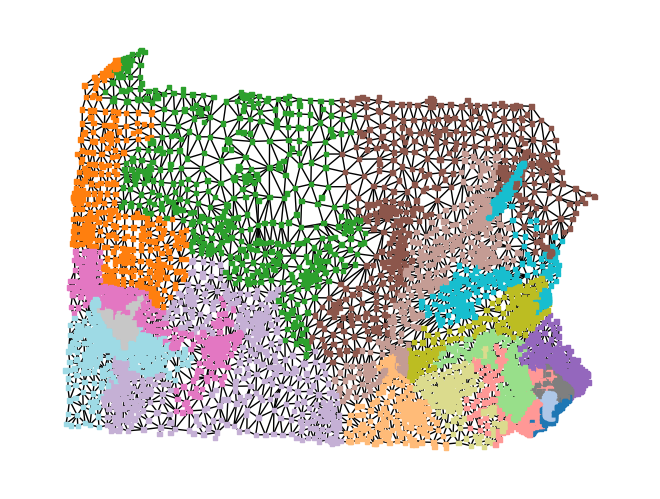

 70%|███████   | 7/10 [01:31<00:39, 13.16s/it]

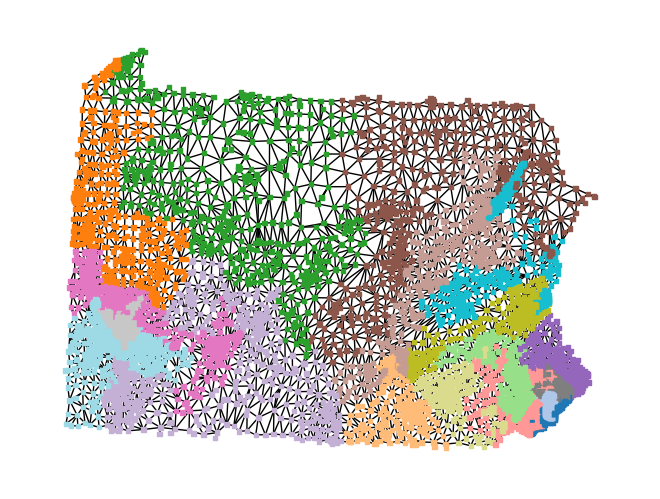

 80%|████████  | 8/10 [01:44<00:26, 13.36s/it]

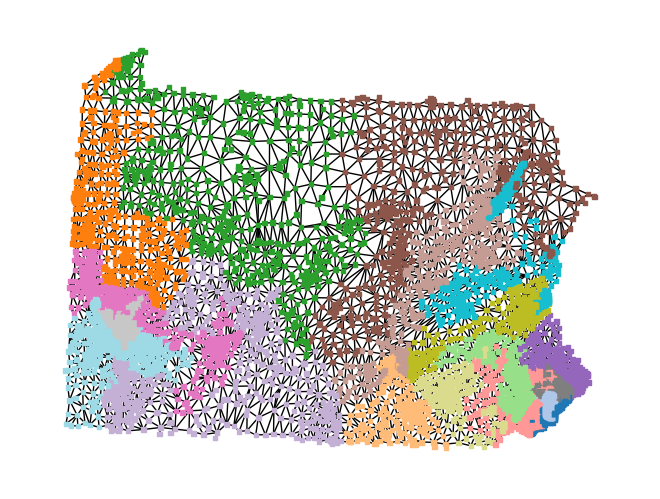

 90%|█████████ | 9/10 [01:58<00:13, 13.43s/it]

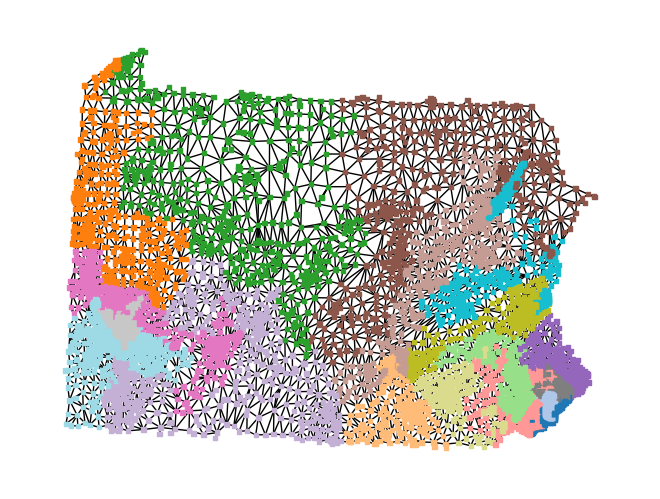

100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


In [ ]:
# boundary
anim_boundary_chain=MarkovChain(
    proposal=propose_random_flip, 
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound,
        single_flip_contiguous
        # inclusion_demo
    ],    
    accept=county_VRA_accept, 
    initial_state=initial_partition,
    total_steps= 10
)

#bsw = []
#bmm = []
#beg = []
#bce = []
i = 0

for part in anim_boundary_chain.with_progress_bar():
    #bsw.append(part["PRES16"].wins("First"))
    #bmm.append(mean_median(part["PRES16"]))
    #beg.append(efficiency_gap(part["PRES16"]))
    #bce.append(len(part["cut_edges"]))

    plt.figure()
    nx.draw(xgraph, 
            pos = {node:(xgraph.nodes[node]["C_X"],xgraph.nodes[node]["C_Y"]) for node in xgraph.nodes()},
            node_color = [dict(part.assignment)[x] for x in xgraph.nodes()] ,
            node_size = ns, 
            node_shape ='s',
            cmap = 'tab20')
    #plt.savefig(f"./Figures/bound_{i}.png")
    plt.show()

In [35]:
#Create Markov Chains  *****
recom_chain = MarkovChain(
    proposal=proposal, # using recom
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition,
    total_steps= 500
)

In [26]:
recom_chain

<MarkovChain [50 steps]>

In [47]:
# Run the chain, putting the sorted Democratic vote percentages
# into a pandas DataFrame for analysis and plotting. *****

# This will take about 30 minutes.

data = pandas.DataFrame(
    sorted(partition["PRES16"].percents("Second"))
    for partition in recom_chain.with_progress_bar()
)



100%|██████████| 500/500 [05:56<00:00,  1.40it/s]


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [28]:
data

0         1         2         3         4         5         6   \
0   0.271129  0.278749  0.321629  0.395760  0.399630  0.407107  0.410071   
1   0.271129  0.278749  0.321629  0.395760  0.399630  0.407107  0.410071   
2   0.271129  0.278749  0.321629  0.395760  0.399630  0.407107  0.410071   
3   0.271129  0.278749  0.321629  0.395760  0.395997  0.399630  0.410071   
4   0.271129  0.278749  0.321629  0.395760  0.395997  0.399630  0.410071   
5   0.271129  0.278749  0.321629  0.395760  0.395997  0.399630  0.410071   
6   0.269465  0.280323  0.321629  0.395760  0.395997  0.399630  0.410071   
7   0.269465  0.280323  0.321629  0.383976  0.395997  0.399630  0.422173   
8   0.269465  0.280323  0.321629  0.383976  0.395997  0.399630  0.422173   
9   0.269465  0.280067  0.321629  0.383976  0.395997  0.399630  0.422173   
10  0.269465  0.280067  0.321629  0.383976  0.395997  0.399630  0.418883   
11  0.269465  0.280067  0.321629  0.375790  0.383976  0.399630  0.418883   
12  0.269465  0.280067  0.321629  0.374654  0.383976  0.399630  0.418883   
13  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.418883   
14  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.418883   
15  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.416636   
16  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.416636   
17  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.416636   
18  0.269465  0.280067  0.321629  0.374654  0.382820  0.383976  0.416636   
19  0.269465  0.280067  0.321629  0.382820  0.383976  0.395116  0.416636   
20  0.269465  0.280067  0.321629  0.382820  0.383976  0.395116  0.416636   
21  0.269465  0.280067  0.321629  0.382820  0.383976  0.395116  0.416636   
22  0.269465  0.280067  0.321629  0.382820  0.383976  0.395116  0.416636   
23  0.268912  0.280067  0.324408  0.382820  0.383976  0.395116  0.416636   
24  0.268912  0.280067  0.324408  0.382820  0.383976  0.395116  0.413300   
25  0.268912  0.280067  0.324408  0.360478  0.382820  0.383976  0.413300   
26  0.268912  0.282102  0.324408  0.360478  0.382097  0.383976  0.413300   
27  0.268912  0.282102  0.324408  0.360478  0.382097  0.383976  0.413300   
28  0.268912  0.282102  0.324408  0.360478  0.382097  0.387471  0.413300   
29  0.266720  0.282102  0.324408  0.360478  0.382097  0.387471  0.415801   
30  0.279189  0.282102  0.324408  0.360478  0.382097  0.387471  0.415801   
31  0.279189  0.282102  0.324408  0.360478  0.382097  0.387471  0.415801   
32  0.279189  0.282102  0.324408  0.360478  0.382097  0.387471  0.414024   
33  0.279189  0.282102  0.324408  0.360478  0.382097  0.387471  0.415604   
34  0.279189  0.282102  0.324408  0.360478  0.382097  0.387471  0.406115   
35  0.270651  0.282102  0.324408  0.360478  0.382097  0.387471  0.406115   
36  0.270651  0.282102  0.324408  0.382097  0.384703  0.387471  0.406115   
37  0.270651  0.282102  0.324408  0.382097  0.384703  0.387471  0.406115   
38  0.270651  0.282102  0.324408  0.382097  0.384703  0.387471  0.406115   
39  0.270651  0.282102  0.324408  0.382097  0.387471  0.390793  0.406115   
40  0.270651  0.276813  0.324408  0.382097  0.387471  0.390793  0.406115   
41  0.270651  0.276813  0.324408  0.382097  0.387471  0.390793  0.406115   
42  0.270651  0.276813  0.324408  0.382097  0.387471  0.390793  0.409462   
43  0.270651  0.276813  0.324408  0.386439  0.387471  0.390793  0.409462   
44  0.270651  0.276813  0.324408  0.386439  0.387471  0.390793  0.409462   
45  0.270651  0.276813  0.324408  0.386439  0.387471  0.388541  0.409462   
46  0.270651  0.276813  0.324408  0.386439  0.387471  0.388541  0.408700   
47  0.270651  0.276813  0.324408  0.386439  0.387471  0.388541  0.408700   
48  0.270651  0.276813  0.324408  0.386439  0.388541  0.390454  0.406576   
49  0.270651  0.276813  0.324408  0.388541  0.390454  0.396287  0.406576   

          7         8         9         10        11        12        13  \
0   0.422342  0.426677  0.436373  0.474600  0.503017  0.5

In [48]:
# Plot in comparison to ENACTED 2011 and REMEDIAL 2018 outcomes
# "dummy" chain to access the Remedial partition

# add 'dummy' for 2011
 
initial_partition_remedial = gerrychain.GeographicPartition(graph,
                              "REMEDIAL",
                              updater)

ideal_population_remedial = sum(initial_partition_remedial["population"].values())/ len(initial_partition_remedial)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal_remedial = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population_remedial, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)  

recom_chain_remedial = MarkovChain(
    proposal=proposal_remedial,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
        #VRA_cutoffs
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition_remedial,
    total_steps= 2
)
data_remedial = pandas.DataFrame(
    sorted(partition["PRES16"].percents("Second"))
    for partition in recom_chain_remedial.with_progress_bar()
)

100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


In [32]:
initial_partition_enacted2011 = gerrychain.GeographicPartition(graph,
                              "CD_2011",
                              updater)

ideal_population_enacted2011 = sum(initial_partition_enacted2011["population"].values())/ len(initial_partition_enacted2011)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal_enacted2011 = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population_enacted2011, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)  

recom_chain_enacted2011 = MarkovChain(
    proposal=proposal_enacted2011,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
        #VRA_cutoffs
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition_enacted2011,
    total_steps= 2
)
data_enacted2011 = pandas.DataFrame(
    sorted(partition["PRES16"].percents("Second"))
    for partition in recom_chain_enacted2011.with_progress_bar()
)

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


In [ ]:
data_remedial

0         1        2         3        4         5        6   \
0  0.263375  0.276084  0.31107  0.322763  0.34975  0.364233  0.39653   
1  0.263375  0.276084  0.31107  0.322763  0.34975  0.364233  0.39653   

         7         8         9         10        11        12       13  \
0  0.450932  0.450969  0.486463  0.505825  0.510256  0.548253  0.60034   
1  0.450932  0.450969  0.486463  0.505825  0.508602  0.548253  0.60034   

         14        15        16        17  
0  0.639377  0.647079  0.745944  0.929407  
1  0.639377  0.647079  0.746710  0.929407

In [33]:
data_enacted2011

0         1         2         3         4         5         6   \
0  0.279564  0.314540  0.350893  0.365173  0.373249  0.387787  0.391405   
1  0.279564  0.333109  0.350893  0.365173  0.373249  0.387787  0.391405   

         7         8         9         10        11       12        13  \
0  0.398925  0.447205  0.459701  0.464711  0.498762  0.50269  0.512786   
1  0.398925  0.427140  0.459701  0.464711  0.498762  0.50269  0.512786   

         14        15        16        17  
0  0.673152  0.680399  0.814657  0.923435  
1  0.673152  0.680399  0.814657  0.923435

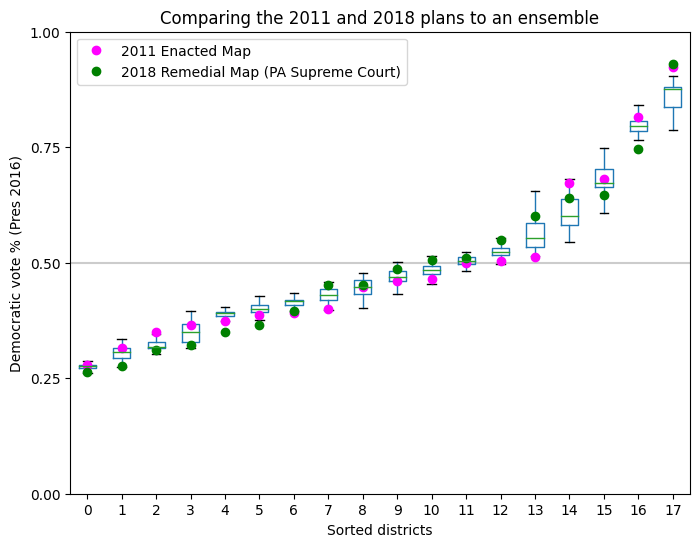

In [49]:
# Plot of histograms of districts in ensemble ranked according to % of democratic vote
# Compare with actual enacted maps: 2011 and 2018 *****

fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, showfliers=False, positions=range(0,len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
data_enacted2011.iloc[0].plot(style="o", color="magenta", ax=ax, label="2011 Enacted Map")
data_remedial.iloc[0].plot(style="o", color="green", ax=ax, label="2018 Remedial Map (PA Supreme Court)")

#initial_partition["PRES16"].percents("Second").plot(style="bo", ax=ax)

# Annotate
ax.set_title("Comparing the 2011 and 2018 plans to an ensemble")
ax.set_ylabel("Democratic vote % (Pres 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

ax.legend()

plt.show()

In [50]:
# Histogram showing what the count of districts for each party was vs the one for the map enacted.

d_wins_counters = []
d_wins_interpolated = []

for i in range(len(data)):
    v = data.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated.append(d__dists_interpolated)

In [51]:
# print(d_wins_counters)
# print(d_wins_interpolated)

print(sorted(d_wins_interpolated))


[5.894129717520156, 5.894129717520156, 6.467817048463346, 6.467817048463346, 6.467817048463346, 6.467817048463346, 6.542141870004203, 6.542141870004203, 6.5429908480371815, 6.5429908480371815, 6.5429908480371815, 6.5429908480371815, 6.568336694917679, 6.587160793200959, 6.607791480614267, 6.607791480614267, 6.607791480614267, 6.640332771581088, 6.658252279788166, 6.658252279788166, 6.658252279788166, 6.658252279788166, 6.674883328722671, 6.676156406096414, 6.679136045557094, 6.679136045557094, 6.679136045557094, 6.679136045557094, 6.679136045557094, 6.679136045557094, 6.679136045557094, 6.6838837690775, 6.6838837690775, 6.6838837690775, 6.700473548054442, 6.700473548054442, 6.700473548054442, 6.757466007788681, 6.757466007788681, 6.758711758754069, 6.758711758754069, 6.764914538528028, 6.764914538528028, 6.777278492437381, 6.777278492437381, 6.777278492437381, 6.777278492437381, 6.777278492437381, 6.777278492437381, 6.777278492437381, 6.777676285025013, 6.777676285025013, 6.78303209165

In [52]:
# Calculate interpolation score for 2011 enacted map:
d_wins_counters_enacted2011 = []
d_wins_interpolated_enacted2011 = []

for i in range(len(data_enacted2011)):
    v = data_enacted2011.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters_enacted2011.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated_enacted2011.append(d__dists_interpolated)

In [53]:
d_wins_interpolated_enacted2011

[6.684776526411044, 6.684776526411044]

In [54]:
# Calculate interpolation score for remedial map:
d_wins_counters_remedial = []
d_wins_interpolated_remedial = []

for i in range(len(data_remedial)):
    v = data_remedial.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters_remedial.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated_remedial.append(d__dists_interpolated)

In [55]:
d_wins_interpolated_remedial

[8.30085026129922, 8.30085026129922]

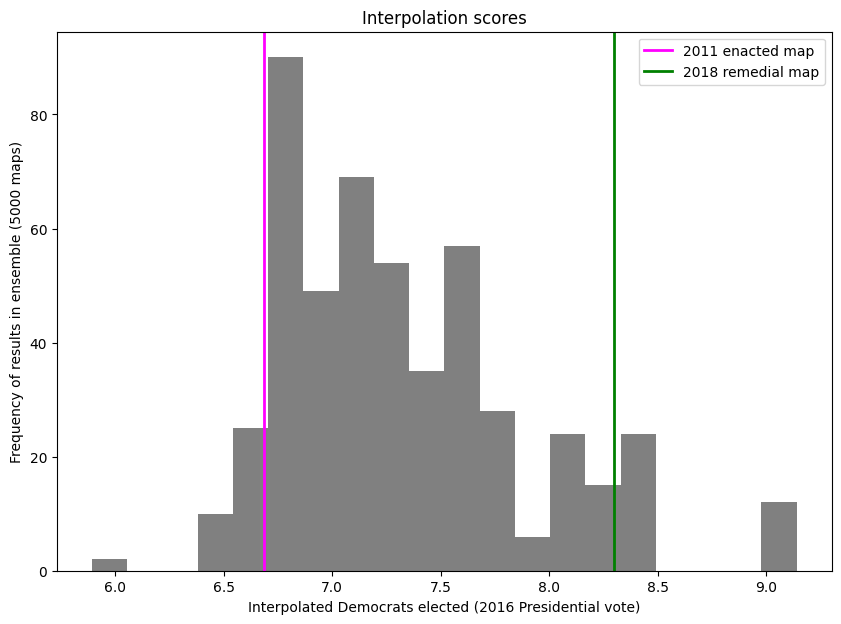

In [56]:
## Interpolation plot *****
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(d_wins_interpolated, bins = 20, color="gray")

ax.set_title("Interpolation scores")
ax.set_ylabel("Frequency of results in ensemble (5000 maps)")
ax.set_xlabel("Interpolated Democrats elected (2016 Presidential vote)")
plt.axvline(x = d_wins_interpolated_enacted2011[0], color = 'magenta', lw = 2, label = '2011 enacted map')
plt.axvline(x = d_wins_interpolated_remedial[0], color = 'green', lw = 2, label = '2018 remedial map') 

# Show plot
plt.legend()

plt.show()

In [57]:
# Plots of frequency for representative index and calculation of 2011's representative score
# Exact representatitve score *****


mean_d_wins_interpol = sum(d_wins_interpolated) / len(d_wins_interpolated)



enacted2011_interpolated = d_wins_interpolated_enacted2011[0] # This is for enacted


distances_from_mean_d_wins = []

for result in d_wins_interpolated:
    distances_from_mean_d_wins.append(abs(result - mean_d_wins_interpol))


# print(distances_from_mean_d_wins)
enacted2011_rscore = distances_from_mean_d_wins[0]
print("Enacted R-score: ", enacted2011_rscore)


count_worse_than_2011 = 0
for rscore in distances_from_mean_d_wins:
    # print(rscore)
    if rscore > enacted2011_rscore:
        count_worse_than_2011 = count_worse_than_2011 + 1
        
print(count_worse_than_2011)

print(count_worse_than_2011*1.0 / len(distances_from_mean_d_wins)*1.0)

Enacted R-score:  0.22702334385861977
351
0.702


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


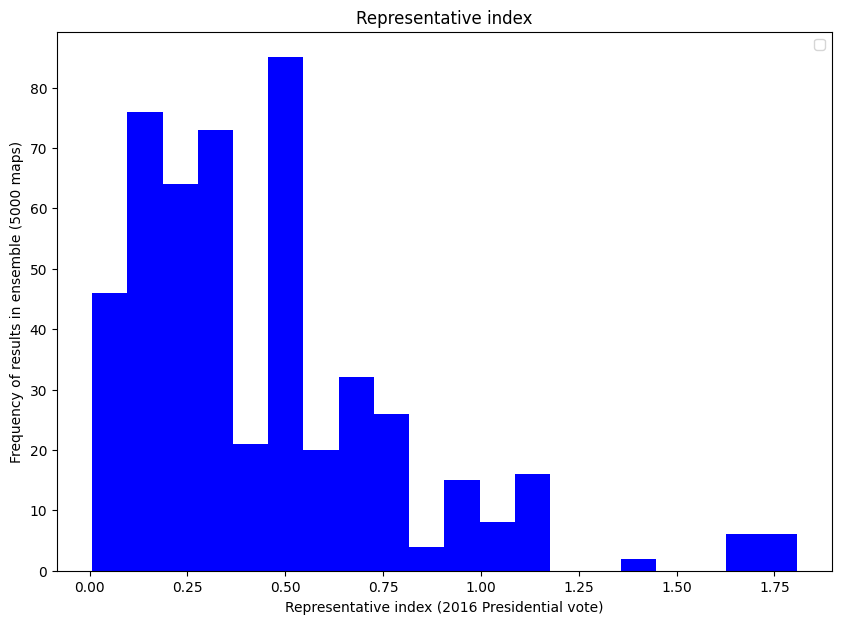

In [58]:
# Histogram for representative index *****

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(distances_from_mean_d_wins, bins = 20, color="blue")

ax.set_title("Representative index")
ax.set_ylabel("Frequency of results in ensemble (5000 maps)")
ax.set_xlabel("Representative index (2016 Presidential vote)")
# plt.axvline(x = distances_from_mean_d_wins[0], color = 'magenta', lw = 2, label = '2011 enacted map')
# plt.axvline(x = d_wins_interpolated_remedial[0], color = 'green', lw = 2, label = '2018 remedial map') 
plt.legend()

# Show plot
plt.show()

In [1]:
# Based on these results, the 2011 map does not appear to be a terrible outlier. 
# Note: only 5000 iterations of chain.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01722cce-db8d-4a90-9749-af129fe2802b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>